# Assignment 4: Seq2seq
_Word Representations and Language Models (WS 23/24)_


***

In this week's assignment, you will learn how to train a sequence-to-sequence model for translating text from German into English. First, you will train a custom LSTM model from scratch using a parallel corpus. Next, you will evaluate the model by comparing the prediction with the correct translation. Finally, you will compare your LSTM model with a state-of-the-art transformer-based model.



In [1]:
from sklearn.model_selection import train_test_split
from nltk.metrics import edit_distance 
from time import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import json

import torch
import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.utils import get_tokenizer

## Task 1: Load and Preprocess Dataset

Sequence-to-Sequence (seq2seq) models can be used in various NLP tasks, including entity recognition and text summarization. In this assignment, neural machine translation is the main topic, where sentences serve as both the input and the output. 

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Load the Dataset</b> 
</div>

Fist, you need to obtain some training data from [manythings.org/anki/](http://www.manythings.org/anki/). This website provides datasets for various languages, which we will use to train our model for translating text into English. We ask you to complete the following steps:

1. Choose one of the datasets containing sentence pairs. In general, you can pick any language, but you may encounter unique problems with some of them. If you want to play it safe, use the [German](http://www.manythings.org/anki/deu-eng.zip) variant. You also want to choose a language with at least a few thousand sentence pairs available. Download the .zip file in the language you would like to work with.
2. Next, create a dataset on kaggle. This allows us to access the dataset more conveniently. We suggest using the "Upload Data" Option in the data section on the right-hand side. 
3. Read the text file containing the sentence pairs. Notice that the text file is tab delimited. You may want to limit the size of the dataset to 50000 sentence pairs, to keep training times acceptable. But feel free to experiment with bigger corpora.
4. Print the first five rows of your dataset.

In [2]:
# Function which reads txt file and returns a dataframe
def read_text_file(path, lang_1, lang_2):
    df = pd.read_csv(path, delimiter='\t', header=None, names=[lang_1, lang_2, "license"])
    df.drop(columns=["license"], inplace=True)
    return df

# Read txt file
path = "/kaggle/input/bilingual-sentence-pairs-deueng/deu.txt"
sentence_pairs = read_text_file(path, "english", "german")
sentence_pairs.tail()

,english,german
255812,If someone who doesn't know your background sa...,"Wenn jemand Fremdes dir sagt, dass du dich wie..."
255813,If someone who doesn't know your background sa...,"Wenn jemand, der nicht weiß, woher man kommt, ..."
255814,It may be impossible to get a completely error...,"Es ist wohl unmöglich, einen vollkommen fehler..."
255815,I know that adding sentences only in your nati...,"Ich weiß wohl, dass das ausschließliche Beitra..."
255816,Doubtless there exists in this world precisely...,Ohne Zweifel findet sich auf dieser Welt zu je...


In [3]:
# Limit the size of the training corpus
sentence_pairs = sentence_pairs.sample(n=50000, random_state=42)

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Preprocessing</b> 
</div>

Now that you have imported the dataset, we ask you to perform a series of preprocessing steps. Those will make training easier.

1. Remove the unnecessary third column containing licence information from the data set.
2. Transform both sentences into lower case.


In [4]:
# Transform sentences into lower case
sentence_pairs["english"] = sentence_pairs['english'].str.lower()
sentence_pairs["german"] = sentence_pairs['german'].str.lower()

sentence_pairs.tail()

,english,german
203106,i worked three years as tom's assistant.,ich habe drei jahre als toms assistent gearbei...
70627,why are you still here?,warum sind sie noch hier?
42032,tom can hardly walk.,tom kann kaum laufen.
157030,i brush my teeth after breakfast.,nach dem frühstück putze ich mir die zähne.
96310,the jury found tom guilty.,die geschworenen befanden tom für schuldig.


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Encode & Decode Text Sequences</b> 
</div>

A Seq2Seq model requires that we convert the input and output into integer sequences of a fixed length. To achieve this, we can use the [Tokenizer](https://pytorch.org/text/stable/data_utils.html#torchtext.data.utils.get_tokenizer) provided by PyTorch. We ask you to implement the following steps:

1. Calculate the maximum sequence length (number of tokens) for both languages (i.e. the longest sentence). You will need this information later to pad the input sequence.
2. Create tokenizers for both languages in your training corpus using the [get_tokenizer()](https://pytorch.org/text/stable/data_utils.html#torchtext.data.utils.get_tokenizer) method, and build the corresponding vocabularies with the [build_vocab_from_iterator()](https://pytorch.org/text/stable/vocab.html#build-vocab-from-iterator) method. Print the sizes of the resulting vocabulary.
3. Implement a function `encodeSequence()` that uses the tokenizers to encode the sentences in your corpus to vectors, which we can feed into the model for training. Note that you also need to pad the sequence to the maximal length occurring for each language. This is where the maximum sequence lengths are helpful. [Consider this example](https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html#data-processing).
4. Implement a function `decodeSquence()` that converts the vectors back to text. We will use the function later to compare the predictions of our model to the correct translations.
5. Test your functions by first encoding a German and English sentence and then decoding the token ID vector back into textual form. You can source your example from the dataset or get creative by coming up with  your own example sentence.


In [5]:
# Initiate the tokenizer
tokenizer = get_tokenizer("basic_english")

# Tokenizer helper function
def yield_tokens(data, tokenizer):
    for line in data:
        yield tokenizer(line)

# List of special tokens to be added to the vocabulary        
special_tokens = [
    "<pad>",   # Padding token for sequence padding
    "<unk>",   # Unknown token for out-of-vocabulary words
    "<sos>",   # Start-of-sequence token to indicate the beginning of a sequence
    "<eos>"    # End-of-sequence token to indicate the end of a sequence
]
        
# Build vocabulary for english
sents_en = sentence_pairs["english"].tolist()
vocab_en = build_vocab_from_iterator(yield_tokens(sents_en, tokenizer), specials=special_tokens)

# Build vocabulary for german
sents_de = sentence_pairs["german"].tolist()
vocab_de = build_vocab_from_iterator(yield_tokens(sents_de, tokenizer), specials=special_tokens)

# Set default index for unknown tokens
vocab_en.set_default_index(vocab_en["<unk>"])
vocab_de.set_default_index(vocab_de["<unk>"])

In [6]:
# Get number of tokens in vocabulary
eng_vocab_size = len(vocab_en)
deu_vocab_size = len(vocab_de)

# Print vocabulary sizes
print('Tokens in English Vocabulary:\t', eng_vocab_size)
print('Tokens in German Vocabulary:\t', deu_vocab_size)

Tokens in English Vocabulary:	 9765
Tokens in German Vocabulary:	 17491


In [7]:
# Function to convert sentences to vectors
def encodeSequence(vocab, max_length, sent):
    """Tokenize a sentence, convert tokens to IDs, and pad the sequence."""
    
    # Tokenize the sentence and convert to indices;
    # Prepend start token and append end token
    token_indices = [vocab['<sos>']] + [vocab[token] for token in tokenizer(sent)] + [vocab['<eos>']]

    # Pad the sequence to the specified max_length using the padding token ID (0)
    length = min(len(token_indices), max_length)
    sequence_padded = torch.zeros(max_length, dtype=torch.long)
    sequence_padded[:length] = torch.tensor(token_indices[:length], dtype=torch.long)

    return sequence_padded

In [8]:
# Function to convert vectors to sentences
def decodeSequence(sequence, index_to_word, sos_index, eos_index):
    """Converts a list of token IDs to text."""
    
    decoded_sequence = []
    for idx in sequence:
        if idx == sos_index:  # Skip the SOS token
            continue
        if idx == eos_index:  # Stop at the first EOS token
            break
        word = index_to_word[idx] if idx < len(index_to_word) else "<unk>"
        decoded_sequence.append(word)
    return ' '.join(decoded_sequence)

In [9]:
# Find maximum length for english languages
lengths_en = sentence_pairs["english"].str.split().apply(len)
max_length_en = max(lengths_en.to_list())

# Find maximum length for german languages
lengths_de = sentence_pairs["german"].str.split().apply(len)
max_length_de = max(lengths_de.to_list())

print('Maximum sequence length in English:\t %d' % max_length_en)
print('Maximum sequence length in German:\t %d' % max_length_de)

Maximum sequence length in English:	 101
Maximum sequence length in German:	 76


Now we can convert the text into numeric values, i.e. tokenize the data. This lets the neural network work with the input data. When we run the tokenizer, it creates a vocabulary which is used to convert each sentence into a vector. When we feed our sequences of word IDs into the model, each sequence must be the same length. To achieve this, a padding is added to each sequence that is shorter than the maximum length.

In [10]:
# Example sentences to test ("abc" to simulate unknown token)
example = "I saw a cat abcd in the park!"

# Encode the sentences using the previously defined function
example_encoded = encodeSequence(vocab_en, max_length_en, example)

# Print the encoded sequence
print("Sentence encoded as vector constructed out of word IDs:\n" + str(example_encoded.tolist()))


Sentence encoded as vector constructed out of word IDs:
[2, 6, 213, 13, 391, 1, 19, 10, 476, 171, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [11]:
# Decode the sentences using the previously defined function
example_decoded = decodeSequence(example_encoded, vocab_en.get_itos(), vocab_en['<sos>'], vocab_en['<eos>'])

# Print the encoded sequence
print("Token IDs decoded:\n" + str(example_decoded))

Token IDs decoded:
i saw a cat <unk> in the park !


In [12]:
# Example sentences to test 
examples = "Ich sah eine Katze im Park!"

# Encode the sentences using the previously defined function
test_sequence = encodeSequence(vocab_de, max_length_de, examples)

# Print the encoded sequence
print("Sentence encoded as vector constructed out of word IDs:\n" + str(test_sequence.tolist()))

Sentence encoded as vector constructed out of word IDs:
[2, 6, 255, 33, 406, 57, 979, 27, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


<b>Step 3: Split Corpus into Training- and Test-Datasets</b> 
</div>

As the final preprocessing step, we ask you to split the dataset into a training and test set before encoding them separately using the function we defined earlier. Please complete the following tasks:

1. Obtain a train and test dataset by splitting the corpus. The training dataset should contain roughly 80% of all sentences. You may want to restrict your test dataset even further due to memory restrictions. 
2. Encode all sentences using the tokenizers you created earlier. Also, don't forget to pad the input and output sequence.

In [13]:
# Split data into train and test set
train, test = train_test_split(sentence_pairs, test_size=0.01, random_state = 42)

print(f"Number of training examples: \t {train.shape[0]}")
print(f"Number of test examples: \t {test.shape[0]}")

Number of training examples: 	 49500
Number of test examples: 	 500


We will use German and English sentences as the input and target sequence. But first we need to encode both sentences. This is needed for both the training and test datasets.

In [14]:
# Encode sequences in training data
train_X = [encodeSequence(vocab_de, max_length_de, sent) for sent in train["german"].tolist()]
train_y = [encodeSequence(vocab_en, max_length_en, sent) for sent in train["english"].tolist()]

# Encode sequences in test data
test_X = [encodeSequence(vocab_de, max_length_de, sent) for sent in test["german"].tolist()]
test_y = [encodeSequence(vocab_en, max_length_en, sent) for sent in test["english"].tolist()]

## Task 2: Train Seq2seq Model

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Define the Model</b> 
</div>

Since the data is now in the correct format, we can proceed with training a LSTM model. Below is a model definition that you can use. It is totally fine to use this simple model architecture, but feel free to optimize the architecture or come up with your own. Here are some ideas: you could increase the number of parameters, add layers, change the learning rate, etc. Here are some resources you can use as inspiration.

Some Code Examples:

* [Translation With a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
* [Sequence to Sequence Learning with Neural Networks](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)

Documentation:

- [Dropout layer](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
- [Dense layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [LSTM layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)
- [GRU layer](https://pytorch.org/docs/stable/generated/torch.ao.nn.quantized.dynamic.GRU.html)
- [Softmax layer](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
- [Optimizers](https://pytorch.org/docs/stable/optim.html)

In [15]:
# Parameters
in_vocab = deu_vocab_size # German vocab size
out_vocab = eng_vocab_size # English vocab size
in_timesteps = max_length_de # Length of the input sequence 
out_timesteps = max_length_en # Length of the output sequence 
units = 512 # Number of neurons
learning_rate = 0.001 # Learning rate

In [16]:
## Model definition

import torch
import torch.nn as nn
import torch.optim as optim

class Seq2SeqModel(nn.Module):
    def __init__(self, in_vocab, out_vocab, units, in_timesteps, out_timesteps):
        super(Seq2SeqModel, self).__init__()
        self.in_timesteps = in_timesteps
        self.out_timesteps = out_timesteps
        self.units = units
        self.embedding = nn.Embedding(in_vocab, units, padding_idx=0)
        self.lstm1 = nn.LSTM(units, units, batch_first=True)
        self.lstm2 = nn.LSTM(units, units, batch_first=True)
        self.dense = nn.Linear(units, out_vocab)

    def forward(self, x):
        x = self.embedding(x)
        x = x.flip(1)  # Reverse the input sequence
        x, _ = self.lstm1(x)

        # Replicate the last output for the output sequence length
        x = x[:, -1, :].unsqueeze(1).repeat(1, self.out_timesteps, 1)
        
        x, _ = self.lstm2(x)
        x = self.dense(x)
        return x

In [17]:
# Model instantiation
model = Seq2SeqModel(in_vocab, out_vocab, units, in_timesteps, out_timesteps)

# Define optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss(ignore_index=0)  # Assuming index 0 is for padding

In [18]:
print("Model Architecture:", model)

Model Architecture: Seq2SeqModel(
  (embedding): Embedding(17491, 512, padding_idx=0)
  (lstm1): LSTM(512, 512, batch_first=True)
  (lstm2): LSTM(512, 512, batch_first=True)
  (dense): Linear(in_features=512, out_features=9765, bias=True)
)


svg image

**Briefly answer the following questions:**

1. Describe the implementation of the encoder and decoder components and explain how the model's architecture corresponds to the abstract Seq2Seq architecture depicted in the preceding figure.
2. We reverse the input sequence with `x = x.flip(1)`. Can you explain the intuition behind reversing the input sequence? _(Hint: The authors of this week's paper mention possible interpretations.)_

1. **Embedding Layer (`nn.Embedding`)**:
   - The embedding layer is used to convert input word indices into dense vectors of a fixed size.
   - `in_vocab` is the size of the input vocabulary (the number of unique words), and `units` is the dimensionality of the embedding vectors.
   - `padding_idx=0` indicates that the zero index is used for padding and the embedding for this index will be a zero vector. This is useful when dealing with sequences of different lengths.

2. **First LSTM Layer (`nn.LSTM`)**:
   - This is the first LSTM (Long Short-Term Memory) layer, which processes the sequence data.
   - The input size and hidden size of the LSTM are both set to `units`. In an LSTM, the input size is the dimension of the input features (here, it's the embedding size), and the hidden size is the dimension of the hidden state and cell state.
   - `batch_first=True` indicates that the input and output tensors are provided as `(batch, seq, feature)`.

3. **Sequence Reversal (`x.flip(1)`)**:
   - This step reverses the input sequence along the time dimension (sequence length). It's a way to process the input in reverse order, which is a technique sometimes used in sequence-to-sequence models.

4. **Sequence Replication**:
   - Here, the last output of the first LSTM layer is replicated for the length of the output sequence. This is a custom way to bridge between the encoder and decoder parts of a sequence-to-sequence model, effectively preparing the last hidden state of the encoder to be the input for the decoder.

5. **Second LSTM Layer (`nn.LSTM`)**:
   - This is the second LSTM layer, which serves as the decoder in the sequence-to-sequence architecture.
   - It's configured similarly to the first LSTM layer. In a typical seq2seq model, this layer would generate the output sequence, but here it's processing the replicated hidden state from the first LSTM.

6. **Dense (Fully Connected) Layer (`nn.Linear`)**:
   - This layer is a standard fully connected neural network layer.
   - It transforms the output of the second LSTM layer to the desired output size (`out_vocab`), which is the size of the output vocabulary. This layer is used for mapping the LSTM outputs to the vocabulary space.

7. **Output of the Model**:
   - The final output of the model after the dense layer is a sequence of logits, where each logit vector has a length equal to the size of the output vocabulary. These logits can be converted to probabilities using a softmax function if needed (for example, during inference to get the most likely word at each sequence position).


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Train the Model</b> 
</div>

To train the model, you need to implement a training loop [similar to this implementation](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb). Train the model for 20 epochs. Make sure to store the training history. Depending on the size of your training corpus, this will take some time. For the German to English dataset, training will take about 30 min **with GPU acceleration enabled.**

**Useful Resources:**
* [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)
* [Dataset or TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)
* [How to Accelerate Training using PyTorch with CUDA](https://cnvrg.io/pytorch-cuda/)
* [Connection between loss.backward() and optimizer.step()](https://stackoverflow.com/questions/53975717/pytorch-connection-between-loss-backward-and-optimizer-step)

**Tutorials:**
* [Translation With a Sequence to Sequence Network and Attention](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)
* [Sequence to Sequence Learning with Neural Networks](https://github.com/bentrevett/pytorch-seq2seq/blob/master/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)
* [Neural Machine Translation by Jointly Learning to Align and Translate](https://github.com/bentrevett/pytorch-seq2seq/blob/master/3%20-%20Neural%20Machine%20Translation%20by%20Jointly%20Learning%20to%20Align%20and%20Translate.ipynb)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

Using device: cuda


In [20]:
# Training Parameters
batch_size = 128  # You can adjust this
epochs = 45  # You can adjust this


**Split into train and validation set:**

In [21]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# Convert data to tensors
train_X = torch.stack(train_X)
train_y = torch.stack(train_y)

# Define the proportion for the validation set (e.g., 80% train, 20% validation)
val_ratio = 0.2
total_samples = len(train_X)

val_size = int(total_samples * val_ratio) # Calculate the number of samples for the validation set
train_size = total_samples - val_size # Calculate the number of samples for the training set

# Use random_split to split the dataset
train_dataset, val_dataset = random_split(
    TensorDataset(train_X, train_y), [train_size, val_size]
)

# Create DataLoader for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

**Functions for training and validation:**

In [22]:
import torch
from tqdm import tqdm

def trainModel(model, device, train_loader, optimizer, loss_function, epoch, epochs):
    """Train the model for one epoch."""
    
    model.train()  # Set the model to training mode, enabling specific layers like dropout, batchnorm etc.
    train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    total_loss = 0  # Initialize total loss for the epoch

    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Transfer batch to the specified device (GPU or CPU)

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation
        output = model(x_batch)  # Forward pass: compute predicted outputs by passing inputs to the model
        output = output.reshape(-1, output.shape[-1])  # Reshape output if necessary for the loss function
        y_batch = y_batch.view(-1)  # Reshape y_batch if necessary to match output dimensions

        loss = loss_function(output, y_batch)  # Compute loss: compare model outputs with actual labels
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Perform a single optimization step (parameter update)
        total_loss += loss.item()  # Accumulate the loss over each batch

    avg_loss = total_loss / len(train_loader)  # Calculate average loss over all batches
    return avg_loss  # Return the average loss for the epoch



def validateModel(model, device, val_loader, loss_function):
    """Evaluate the model."""
    
    model.eval()  # Set the model to evaluation mode, which turns off certain layers like dropout
    total_val_loss = 0  # Initialize total validation loss for the epoch

    with torch.no_grad():  # Disable gradient calculation for validation, saving memory and computations
        for x_val, y_val in val_loader:  # Iterate over batches in the validation loader
            x_val, y_val = x_val.to(device), y_val.to(device)  # Transfer batch to the specified device (GPU or CPU)
            
            val_output = model(x_val)  # Forward pass: compute predictions by passing validation data to the model
            val_output = val_output.reshape(-1, val_output.shape[-1])  # Reshape output if necessary for the loss function
            y_val = y_val.view(-1)  # Reshape y_val if necessary to match output dimensions

            val_loss = loss_function(val_output, y_val)  # Compute loss: compare model predictions with actual labels
            total_val_loss += val_loss.item()  # Accumulate the validation loss over each batch

    avg_val_loss = total_val_loss / len(val_loader)  # Calculate average loss over all validation batches
    return avg_val_loss  # Return the average loss for the validation dataset


**Training for multiple epochs:**

In [23]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# Lists to store loss values
loss_values = []  
loss_values_val = []

# Training Loop with GPU support
for epoch in range(epochs):

    # Training
    avg_loss = trainModel(model, device, train_loader, optimizer, loss_function, epoch, epochs)
    loss_values.append(avg_loss)
    print(f'Training Loss: {avg_loss:.4f}')

    # Validation
    avg_val_loss = validateModel(model, device, val_loader, loss_function)
    loss_values_val.append(avg_val_loss)
    print(f'Validation Loss: {avg_val_loss:.4f}')

# Save your model after training
torch.save(model.state_dict(), 'seq2seq_model.pth')

Epoch 1/45: 100%|██████████| 310/310 [00:39<00:00,  7.93it/s]


Training Loss: 4.1038
Validation Loss: 3.6270


Epoch 2/45: 100%|██████████| 310/310 [00:38<00:00,  8.10it/s]


Training Loss: 3.2975
Validation Loss: 3.2978


Epoch 3/45: 100%|██████████| 310/310 [00:37<00:00,  8.18it/s]


Training Loss: 2.8927
Validation Loss: 3.1193


Epoch 4/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 2.5556
Validation Loss: 3.0002


Epoch 5/45: 100%|██████████| 310/310 [00:38<00:00,  8.15it/s]


Training Loss: 2.2598
Validation Loss: 2.9458


Epoch 6/45: 100%|██████████| 310/310 [00:37<00:00,  8.22it/s]


Training Loss: 1.9932
Validation Loss: 2.9783


Epoch 7/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 1.7564
Validation Loss: 2.9812


Epoch 8/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 1.5505
Validation Loss: 3.0920


Epoch 9/45: 100%|██████████| 310/310 [00:38<00:00,  8.14it/s]


Training Loss: 1.3709
Validation Loss: 3.0387


Epoch 10/45: 100%|██████████| 310/310 [00:37<00:00,  8.18it/s]


Training Loss: 1.2115
Validation Loss: 3.0996


Epoch 11/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 1.0767
Validation Loss: 3.1884


Epoch 12/45: 100%|██████████| 310/310 [00:38<00:00,  8.13it/s]


Training Loss: 0.9548
Validation Loss: 3.2885


Epoch 13/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.8521
Validation Loss: 3.3427


Epoch 14/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.7616
Validation Loss: 3.4636


Epoch 15/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 0.6864
Validation Loss: 3.4813


Epoch 16/45: 100%|██████████| 310/310 [00:38<00:00,  8.14it/s]


Training Loss: 0.6178
Validation Loss: 3.5599


Epoch 17/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 0.5579
Validation Loss: 3.6166


Epoch 18/45: 100%|██████████| 310/310 [00:37<00:00,  8.22it/s]


Training Loss: 0.5046
Validation Loss: 3.6940


Epoch 19/45: 100%|██████████| 310/310 [00:38<00:00,  8.16it/s]


Training Loss: 0.4619
Validation Loss: 3.7446


Epoch 20/45: 100%|██████████| 310/310 [00:37<00:00,  8.22it/s]


Training Loss: 0.4261
Validation Loss: 3.8322


Epoch 21/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.3885
Validation Loss: 3.9048


Epoch 22/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.3607
Validation Loss: 3.9856


Epoch 23/45: 100%|██████████| 310/310 [00:38<00:00,  8.15it/s]


Training Loss: 0.3368
Validation Loss: 4.0065


Epoch 24/45: 100%|██████████| 310/310 [00:37<00:00,  8.19it/s]


Training Loss: 0.3189
Validation Loss: 4.0682


Epoch 25/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 0.2978
Validation Loss: 4.1292


Epoch 26/45: 100%|██████████| 310/310 [00:38<00:00,  8.13it/s]


Training Loss: 0.2795
Validation Loss: 4.1848


Epoch 27/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 0.2671
Validation Loss: 4.2365


Epoch 28/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.2509
Validation Loss: 4.2908


Epoch 29/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 0.2386
Validation Loss: 4.3142


Epoch 30/45: 100%|██████████| 310/310 [00:38<00:00,  8.14it/s]


Training Loss: 0.2331
Validation Loss: 4.3641


Epoch 31/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.2217
Validation Loss: 4.3830


Epoch 32/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.2134
Validation Loss: 4.4636


Epoch 33/45: 100%|██████████| 310/310 [00:38<00:00,  8.15it/s]


Training Loss: 0.2041
Validation Loss: 4.5070


Epoch 34/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 0.1983
Validation Loss: 4.5314


Epoch 35/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.1909
Validation Loss: 4.5597


Epoch 36/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 0.1870
Validation Loss: 4.5545


Epoch 37/45: 100%|██████████| 310/310 [00:38<00:00,  8.14it/s]


Training Loss: 0.1789
Validation Loss: 4.6408


Epoch 38/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.1768
Validation Loss: 4.6482


Epoch 39/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.1713
Validation Loss: 4.7059


Epoch 40/45: 100%|██████████| 310/310 [00:38<00:00,  8.15it/s]


Training Loss: 0.1658
Validation Loss: 4.7055


Epoch 41/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.1628
Validation Loss: 4.7414


Epoch 42/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.1593
Validation Loss: 4.7914


Epoch 43/45: 100%|██████████| 310/310 [00:37<00:00,  8.20it/s]


Training Loss: 0.1527
Validation Loss: 4.7939


Epoch 44/45: 100%|██████████| 310/310 [00:38<00:00,  8.13it/s]


Training Loss: 0.1536
Validation Loss: 4.8259


Epoch 45/45: 100%|██████████| 310/310 [00:37<00:00,  8.21it/s]


Training Loss: 0.1506
Validation Loss: 4.8420


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 3: Plot Training History</b> 
</div>

Plot the training and validation loss for each epoch and provide a short interpretation. Did the model learn? Is the model overfitting or underfitting?

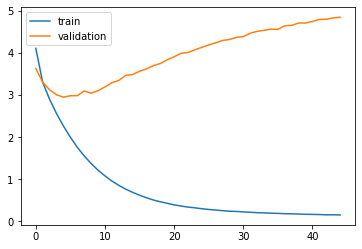

In [24]:
# Plot validation and train loss per epoch
plt.plot(loss_values)
plt.plot(loss_values_val)
plt.legend(['train','validation'])
plt.show()

**Interpret the training history:**

The model clearly was able to learn, as shown by the decreasing loss. After some epochs, the validation loss remains higher than the training loss, which may suggests that the model is subject to some amount of  overfitting.


## Task 3: Evaluate Model

<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 1: Make Predictions</b> 
</div>

We can now test how good the model is at translating. We ask you to implement the following steps:

1. Use the model to translate the sentences in the test dataset. The model will return logits, which you need to convert to probabilites over the whole vocabulary for every output token a using a [softmax layer](https://pytorch.org/docs/stable/generated/torch.nn.functional.softmax.html).  
2. Convert the probabilities into word IDs [torch.argmax()](https://pytorch.org/docs/stable/generated/torch.argmax.html)
3. Convert the word IDs into sentences by matching them to the corresponding words using the function you implemented earlier.

In [25]:
# OPTIONAL: Load the best performing checkpoint
# model = load_model('best_model')

import torch
import numpy as np

def getPredictions(model, device, test_X):
    """Performs predictions using the provided model on the test data."""
    
    model.eval()  # Set the model to evaluation mode

    # Check if test_X is a list of tensors, and if so, stack them into a single tensor
    if isinstance(test_X, list) and all(isinstance(x, torch.Tensor) for x in test_X):
        test_X_tensor = torch.stack(test_X).to(device)
    elif isinstance(test_X, torch.Tensor):
        test_X_tensor = test_X.to(device)
    else:
        raise ValueError("test_X must be a tensor or a list of tensors")

    # Move the tensor to the correct device
    test_X_tensor = test_X_tensor.to(device)

    # No gradients needed for inference
    with torch.no_grad():
        # Forward pass through the model
        raw_predictions = model(test_X_tensor)

        # Apply softmax and argmax to get the most likely class (word index)
        probabilities = torch.nn.functional.softmax(raw_predictions, dim=-1)
        predictions = torch.argmax(probabilities, dim=-1)

        # Move predictions to CPU and convert to NumPy array
        predictions_np = predictions.cpu().numpy()

    return predictions_np

In [26]:
# Get predictions
predictions = getPredictions(model, device, test_X)

# vocab_en is your torchtext Vocab object for English
index_to_word_en = vocab_en.get_itos()  # Get the index-to-string list

sos_index = vocab_en['<sos>']
eos_index = vocab_en['<eos>']
    
decoded_predictions = [decodeSequence(pred, index_to_word_en, sos_index, eos_index) for pred in predictions]

# Print the first decoded prediction
print(f"First test example translated: '{decoded_predictions[0]}'")

First test example translated: 'tom has given a a direction .'


<div style="position:relative;padding:.75rem 1.25rem;margin-bottom:1rem;border:1px solid transparent;border-radius:.25rem;background-color:#dae8fc;border-color:#6c8ebf;color:#0c5460">
<b>Step 2: Compare Predictions with Label</b> 
</div>

Now compare the predictions with the correct translations:

1. Calculate the [edit distance](https://www.nltk.org/api/nltk.metrics.distance.html#nltk.metrics.distance.edit_distance) between predicted English sentence and correct translation. 
2. Calculate the [sentence BLEU score](https://www.nltk.org/api/nltk.translate.bleu_score.html#nltk.translate.bleu_score.sentence_bleu) with the correct translation as reference and the prediction as hypotheses. [Here](https://aclanthology.org/P02-1040.pdf) you can read more about the BLEU Score.
3. Calculate the mean BLEU score and mean edit distance.
3. Print out the worst and the best predictions. 
4. Provide a short assessment of the translation's quality. Did the model capture the key aspects of the input sentence most of the time? 

In [27]:
# Create new dataset for comparison
pred_df = pd.DataFrame({'input' : test["german"], 'actual' : test["english"], 'predicted' : decoded_predictions})
pred_df.head(15)

,input,actual,predicted
176495,tom hat alles auf eine karte gesetzt.,tom put all his eggs in one basket.,tom has given a a direction .
177752,schreib diese worte in dein notizbuch.,write these words in your notebook.,those those to in in grow .
223150,meine freunde standen mir bei während des proz...,my friends stood by me during the court case.,my friends friends me me me in last . .
232758,"es ist nicht klug, eine frau zu fragen, wie al...",asking a woman how old she is is not a good idea.,it ' s not a lot to to thought thought to to .
123253,ich werde tom nie mehr erwähnen.,i'll never mention tom again.,i ' ll never harm tom again .
107545,tom versucht dich hereinzulegen.,tom is trying to trick you.,tom is trying .
10923,tom mag nüsse.,tom likes nuts.,tom likes like .
239323,die videokameras dienen hauptsächlich der absc...,the video cameras are mainly there to deter th...,the stars are without at the sea .
1704,das ist mies.,it's bogus.,that is s .
183264,tom verbrachte den ganzen tag allein auf seine...,tom spent all day alone in his room.,tom spent all alone alone in the afternoon .


In [28]:
# Compare prediction and label using edit distance
pred_df["distance"] = pred_df.apply(lambda x: edit_distance(x["actual"], x["predicted"]), axis=1)
pred_df.head()

,input,actual,predicted,distance
176495,tom hat alles auf eine karte gesetzt.,tom put all his eggs in one basket.,tom has given a a direction .,24
177752,schreib diese worte in dein notizbuch.,write these words in your notebook.,those those to in in grow .,20
223150,meine freunde standen mir bei während des proz...,my friends stood by me during the court case.,my friends friends me me me in last . .,24
232758,"es ist nicht klug, eine frau zu fragen, wie al...",asking a woman how old she is is not a good idea.,it ' s not a lot to to thought thought to to .,38
123253,ich werde tom nie mehr erwähnen.,i'll never mention tom again.,i ' ll never harm tom again .,10


In [29]:
# Best predictions
pred_df.sort_values("distance").head()

,input,actual,predicted,distance
39196,"ich glaube, tom ist beschäftigt.",i think tom is busy.,i think tom is busy .,1
77410,tom und ich arbeiten zusammen.,tom and i work together.,tom and i work together .,1
29848,hast du eine ehefrau?,do you have a wife?,do you have a wife ?,1
175119,die planeten umkreisen die sonne.,the planets revolve around the sun.,the planets revolve around the sun .,1
46877,ich habe drei cousins.,i have three cousins.,i have three cousins .,1


In [30]:
# Worst predictions
pred_df.sort_values("distance").tail()

,input,actual,predicted,distance
254479,als der kleine die neueste playstation-softwar...,when the kid wanted the latest playstation sof...,the the people people the the boy was a he car...,55
254392,ich kann mich nicht mehr an den namen des mädc...,i can't remember the name of the girl who sat ...,"i can ' t stay up on on what , what ' ' ' to to .",57
251978,"wie du weißt, habe ich meinen job verloren, un...","as you know, i've lost my job, so i'm having t...",you you taught how about quickly lower tell of...,61
255438,"ein kleiner junge, der nicht älter als fünf ja...","a young boy, who couldn't have been more than ...","a who who being living , living was not was wa...",81
255498,tom hinterließ seiner urlaubsvertretung schrit...,tom left step-by-step instructions for the per...,tom moved his his his s . .,84


In [31]:
from nltk.translate.bleu_score import sentence_bleu

def calc_bleu(reference, hypothesis):
    reference = reference.split(" ")
    hypothesis = hypothesis.split(" ")
    score = sentence_bleu([reference], hypothesis)
    return score

In [32]:
pred_df["bleu"] = pred_df.apply(lambda x: calc_bleu(x["actual"], x["predicted"]), axis=1)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [33]:
# Best predictions
pred_df.sort_values("bleu").tail()

,input,actual,predicted,distance,bleu
208706,die polizeibeamten nahmen den einbrecher fest.,the police officers arrested the burglar.,the police officers arrested the death .,7,0.614788
153583,tom saß im schneidersitz auf dem bett.,tom sat cross-legged on the bed.,tom sat cross-legged on the floor .,6,0.614788
156400,"er bat mich, ihm das salz zu reichen.",he asked me to pass him the salt.,he asked me to pass him the salt .,1,0.725980
210784,"wisst ihr, warum tom der schule fernbleibt?",do you know why tom is absent from school?,do you know why tom is absent from school ?,1,0.759836
118930,wo wirst du leben?,where are you going to live?,where are you going to,6,0.818731


In [34]:
# Worst predictions
pred_df.sort_values("bleu").head()

,input,actual,predicted,distance,bleu
155681,"bring das buch zu mir, nicht zu tom!","bring the book to me, not to tom.",get out his some tom tom ' ' t .,22,0.0
57212,das tut dir nicht gut.,it's not good for you.,that doesn ' t mean this .,21,0.0
3561,ihr seid eitel.,you're vain.,you ' re .,6,0.0
49980,es wird ihnen gutgehen.,they'll be all right.,they ' ll take fine .,11,0.0
40427,"mach es nicht schwierig, tom.","keep it simple, tom.",don ' t do on tom . tom .,18,0.0


In [35]:
# Calculate mean BLEU score and edit distance
mean_scores = pred_df[["distance", "bleu"]].mean()
print(mean_scores)

distance    18.378000
bleu         0.035754
dtype: float64


 **Interpret the results:**


## Task 4: Comparison with State-of-the-Art (OPTIONAL)


Finally, we want to compare our own model against a state-of-the-art transformer model. We recommend using the model [opus-mt-de-en](https://huggingface.co/Helsinki-NLP/opus-mt-de-en) for German to English translation. If you used a dataset with different languages, [here is a list](https://huggingface.co/Helsinki-NLP) of models trained for translating a variety of languages. We ask you to implement the following:

1. Load the pretrained model and tokenizer for the model [opus-mt-de-en](https://huggingface.co/Helsinki-NLP/opus-mt-de-en) using the transformer package.
2. Use this model to translate the source sentences in the test dataset to English (like we did with the LSTM model). [Here](https://huggingface.co/Lalita/marianmt-th-zh_cn) you can see how to obtain predictions and [here](https://huggingface.co/docs/transformers/tasks/translation) is some more documentation on how to use transformers for translation.

**Analogous to the previous step, compare the predictions with the correct translations:**

3. Calculate the [edit distance](https://www.nltk.org/api/nltk.metrics.distance.html#nltk.metrics.distance.edit_distance) between predicted English sentence and correct translation. 
4. Calculate the [sentence BLEU score](https://www.nltk.org/api/nltk.translate.bleu_score.html#nltk.translate.bleu_score.sentence_bleu) with the correct translation as reference and the prediction as hypotheses.
5. Calculate the mean BLEU score and mean edit distance.
6. Print out the worst and the best predictions. 
7. Provide a short assessment of the translation's quality. How does it perform in comparison to the LSTM model?

In [36]:
del model
torch.cuda.empty_cache()

In [37]:
# Load pretrained tokenizer and model
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer_trf = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-de-en")
model_trf = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-de-en").to(device)

Downloading:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/778k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/750k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/284M [00:00<?, ?B/s]

In [38]:
# Use model to make prediction
examples = test["german"].to_list()
translated = model_trf.generate(**tokenizer_trf(examples, return_tensors="pt", padding=True).to(device))
predictions_trf = [tokenizer_trf.decode(t, skip_special_tokens=True) for t in translated]

In [39]:
# Compare prediction and label using edit distance
pred_df["prediction_trf"] = predictions_trf
pred_df["distance_trf"] = pred_df.apply(lambda x: edit_distance(x["actual"], x["prediction_trf"]), axis=1)
pred_df.head()

,input,actual,predicted,distance,bleu,prediction_trf,distance_trf
176495,tom hat alles auf eine karte gesetzt.,tom put all his eggs in one basket.,tom has given a a direction .,24,9.709386e-232,tom put everything on a card.,20
177752,schreib diese worte in dein notizbuch.,write these words in your notebook.,those those to in in grow .,20,1.120041e-231,write this word in your notebook.,3
223150,meine freunde standen mir bei während des proz...,my friends stood by me during the court case.,my friends friends me me me in last . .,24,6.373704e-155,my friends were with me during the process.,16
232758,"es ist nicht klug, eine frau zu fragen, wie al...",asking a woman how old she is is not a good idea.,it ' s not a lot to to thought thought to to .,38,5.019363e-155,It's not wise to ask a woman how old she is.,36
123253,ich werde tom nie mehr erwähnen.,i'll never mention tom again.,i ' ll never harm tom again .,10,1.288230e-231,I'll never mention tom again.,1


In [40]:
# Best predictions
pred_df.sort_values("distance_trf").head()

,input,actual,predicted,distance,bleu,prediction_trf,distance_trf
108060,tom spricht verhältnismäßig schnell.,tom speaks relatively fast.,tom speaks too a fast .,10,7.579654e-155,tom speaks relatively fast.,0
114739,mein haus hat drei schlafzimmer.,my house has three bedrooms.,my birthday has three months .,16,8.388266e-155,my house has three bedrooms.,0
234893,"kinder reiben sich oft die augen, wenn sie müd...",children often rub their eyes when they are ti...,"children friends are up , , , but children re ...",31,1.164047e-231,children often rub their eyes when they are ti...,0
145820,wir haben noch keine entscheidung getroffen.,we haven't made a decision yet.,we ' ve ve found found chance yet .,21,1.051835e-231,we haven't made a decision yet.,0
88468,tom isst nur weißes fleisch.,tom only eats white meat.,tom just eats a word .,14,1.384293e-231,tom only eats white meat.,0


In [41]:
# Worst predictions
pred_df.sort_values("distance_trf").tail()

,input,actual,predicted,distance,bleu,prediction_trf,distance_trf
252777,die derzeit im bau befindliche fabrik wird am ...,the factory now under construction will assemb...,the british will take possible to be hour a a ...,52,1.120041e-231,the factory currently under construction will ...,45
253994,"tom war nicht bei der sache und nervös, und ma...",tom was distracted and fidgety and mary knew t...,tom was ' t about about mary mary was mary was...,49,6.132749e-155,"Tom wasn't at the thing and nervous, and maria...",45
248205,"wenn du die zeitung zu ende gelesen hast, dann...",i'd like to read the newspaper as soon as you ...,"if you had to lunch , the , , should d having ...",46,1.218332e-231,"If you've finished reading the paper, I'd like...",46
255498,tom hinterließ seiner urlaubsvertretung schrit...,tom left step-by-step instructions for the per...,tom moved his his his s . .,84,2.738930e-232,tom left his leave representation step-by-step...,76
4964,tom beharrte.,tom insisted.,tom was s . .,6,1.218332e-231,The Commission's proposal was based on a propo...,100


In [42]:
from nltk.translate.bleu_score import sentence_bleu

def calc_bleu(reference, hypothesis):
    reference = reference.split(" ")
    hypothesis = hypothesis.split(" ")
    score = sentence_bleu([reference], hypothesis)
    return score

In [43]:
pred_df["bleu_trf"] = pred_df.apply(lambda x: calc_bleu(x["actual"], x["prediction_trf"]), axis=1)

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

In [44]:
# Best predictions
pred_df.sort_values("bleu_trf").tail()

,input,actual,predicted,distance,bleu,prediction_trf,distance_trf,bleu_trf
156788,seine ideen sind mir zu extrem.,his ideas are too extreme for me.,my friends is me of me .,23,0.000000e+00,his ideas are too extreme for me.,0,1.0
53200,ihre antwort ist falsch.,your answer is wrong.,your answer is wrong .,1,6.868092e-78,your answer is wrong.,0,1.0
145820,wir haben noch keine entscheidung getroffen.,we haven't made a decision yet.,we ' ve ve found found chance yet .,21,1.051835e-231,we haven't made a decision yet.,0,1.0
88468,tom isst nur weißes fleisch.,tom only eats white meat.,tom just eats a word .,14,1.384293e-231,tom only eats white meat.,0,1.0
175502,diese angelegenheit ist von großer wichtigkeit.,this matter is of great importance.,this watch is too a great mistake .,15,1.425661e-231,this matter is of great importance.,0,1.0


In [45]:
# Worst predictions
pred_df.sort_values("bleu_trf").head()

,input,actual,predicted,distance,bleu,prediction_trf,distance_trf,bleu_trf
97553,tom sonnt sich.,tom is basking in the sun.,tom could have .,18,7.813508e-232,Tom's sunning.,17,0.0
72320,alle kamen mit dem schrecken davon.,everyone escaped injury.,everybody all all the the . .,19,0.000000e+00,They all got away with the frightening.,32,0.0
51701,tom bekam einen trockenen mund.,tom's mouth went dry.,tom got a an . .,12,0.000000e+00,Tom got a dry mouth.,16,0.0
98788,das tennisspielen hat uns spaß gemacht.,we enjoyed playing tennis.,that was fun us us .,22,0.000000e+00,the tennis game was fun for us.,23,0.0
63007,spiel nicht den helden!,don't try to be a hero.,don ' t eat the . .,13,0.000000e+00,Don't play the hero!,10,0.0


In [46]:
# Calculate mean BLEU score and edit distance
mean_scores = pred_df[["distance_trf", "bleu_trf"]].mean()
print(mean_scores)

distance_trf    10.2720
bleu_trf         0.2201
dtype: float64


 **Interpret:**

As spected the transformer based model performs way better.